# Noise-induced Equalization

A QNN is said to be overparametrized [1] if the number of parameters $M$ is such that the Quantum Fisher Information Matrices (QFIMs), for all the $x$ in the training set, 
simultaneously saturate their achievable rank $R_x$ for at least one parameter vector $\boldsymbol{\theta}$. 

That is, if increasing the number of parameters past some minimal (critical) value $M_c$ does not further increase the rank of any QFIM:
$$        \max_{M\ge M_c, \boldsymbol{\theta}} \text{rank}[F_x(\boldsymbol{\theta})]=R_x$$

The Quantum Fisher Information Matrix for the training sample $x$ is the $M\times M$ square matrix:


$$\begin{align}
    [F_x(\boldsymbol{\theta})]_{ij}=4\text{Re}[&\langle \partial_i\psi(x,\boldsymbol{\theta})|\partial_j\psi(x,\boldsymbol{\theta})\rangle\\
    &-\langle\partial_i\psi(x,\boldsymbol{\theta})|\psi(x,\boldsymbol{\theta})\rangle \langle\psi(x,\boldsymbol{\theta})|\partial_j\psi(x,\boldsymbol{\theta})\rangle]
    \nonumber
\end{align} $$

where $|\partial_i\psi(x,\boldsymbol{\theta})\rangle=\partial|\psi(x,\boldsymbol{\theta})\rangle/\partial \theta_i$. 


In this notebook, we provide code to study the effects of noise on QFIM for both overparametrized and underparametrized QNNs. 

In particular, noise is able to change the relative importance of the eigenvalues of the QFIM. On average they are exponentially suppressed (as pointed out in [2]), 
but at the single level they can also increase. 

We name this phenomenon  **Noise-induced Equalization (NIE)**. See [3] for more details




[1] M. Larocca, N. Ju, D. Garcia-Martin, P. J. Coles, and M. Cerezo, **Theory of overparametrization in quantum neural networks**,  Nat Comput Sci 3, 542 (2023)

[2] D. García-Martín, M. Larocca, and M. Cerezo, **Effects of noise on the overparametrization of quantum neural networks**, Phys. Rev. Res. 6, 013295 (2024)

[3] F. Scala, G. Guarnieri, A. Lucchi, Improving Quantum Neural Networks exploration by Noise-Induced Equalization

In [1]:
import pennylane as qml

import jax
import jax.numpy as jnp
from jax.scipy.linalg import eigh

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

import numpy as np

import os

## Useful functions

In [16]:
def create_circuit(n_qubits, layers, p=0.0, noise_type="depolarizing"):
    noise_gate = qml.DepolarizingChannel
    if noise_type == "depolarizing":
        noise_gate = qml.DepolarizingChannel
    elif noise_type == "phase_damp":
        noise_gate = qml.PhaseDamping
    elif noise_type == "ampl_damp":
        noise_gate = qml.AmplitudeDamping
    elif noise_type == "gen_ampl_damp":
        noise_gate = qml.GeneralizedAmplitudeDamping

    def embedding(x, wires):
        # assert len(x)==1
        for i, wire in enumerate(wires):
            qml.RY((x[i % len(x)]), wires=wire)
        for i, wire in enumerate(wires):
            qml.RZ((x[i % len(x)] ** 2), wires=wire)

    def var_ansatz(
        theta,
        wires,
        rotations=[qml.RX, qml.RZ, qml.RX],
        entangler=qml.CNOT,
    ):
        # the length of `rotations` defines the number of inner layers
        N = len(wires)
        assert len(theta) == 3 * N
        wires = list(wires)

        # each inner layer can have a different rotation
        for in_lay, rot in enumerate(rotations):
            angles = theta[in_lay * N : (in_lay + 1) * N]

            for i, angle in enumerate(angles):
                rot(angle, wires=wires[i % N])
            for qb in wires[:-1]:
                entangler(wires=[wires[qb], wires[qb + 1]])

    if p == 0.0:
        device = qml.device(
            "default.qubit.jax",
            wires=n_qubits,
        )

        @qml.qnode(device, interface="jax")
        def circuit(
            x,
            theta,
        ):

            for i in range(layers):
                embedding(x, wires=range(n_qubits))
                qml.Barrier(only_visual=True)
                var_ansatz(
                    theta[i * params_per_layer : (i + 1) * params_per_layer],
                    wires=range(n_qubits),
                    entangler=qml.CNOT,
                )
                qml.Barrier(only_visual=True)

            return qml.state()
    else:
        dev_ideal = qml.device("default.mixed", wires=n_qubits)
        # apply noise to device
        device = qml.transforms.insert(noise_gate, p, position="all")(dev_ideal)


        @qml.qnode(device, interface="jax")
        def circuit(
            x,
            theta,
        ):

            for i in range(layers):
                embedding(x, wires=range(n_qubits))
                qml.Barrier(only_visual=True)
                var_ansatz(
                    theta[i * params_per_layer : (i + 1) * params_per_layer],
                    wires=range(n_qubits),
                    entangler=qml.CNOT,
                )
                qml.Barrier(only_visual=True)

            return qml.density_matrix(wires=range(n_qubits))

    return circuit


def create_circuit_diabetes(n_qubits, layers, p=0.0, noise_type="depolarizing"):
    noise_gate = qml.DepolarizingChannel
    if noise_type == "depolarizing":
        noise_gate = qml.DepolarizingChannel
    elif noise_type == "phase_damp":
        noise_gate = qml.PhaseDamping
    elif noise_type == "ampl_damp":
        noise_gate = qml.AmplitudeDamping
    elif noise_type == "gen_ampl_damp":
        noise_gate = qml.GeneralizedAmplitudeDamping

    def embedding(x,  wires):
        qml.RX((x[0]), wires=wires[0])
        qml.RX((x[1]), wires=wires[2])

    def var_ansatz(
        theta,
        wires,
    ):
        # the length of `rotations` defines the number of inner layers
        N = len(wires)
        wires = list(wires)

        for i, wire in enumerate(wires):
            qml.RY(theta[i], wires=wire)

        for i, wire in enumerate(wires):
            qml.IsingXX(theta[N + i], wires=[i, (i + 1) % N])

    if p == 0.0:
        device = qml.device(
            "default.qubit.jax",
            wires=n_qubits,
        )  
        @qml.qnode(device, interface="jax")
        def circuit(
            x,
            theta,
        ):
            for i in range(layers):
                embedding(x, wires=range(n_qubits))
                qml.Barrier(only_visual=True)
                var_ansatz(
                    theta[i * params_per_layer : (i + 1) * params_per_layer],
                    wires=range(n_qubits),
                )
                qml.Barrier(only_visual=True)

            return qml.state()
    else:
        dev_ideal = qml.device("default.mixed", wires=n_qubits)
        # apply noise to device
        device = qml.transforms.insert(noise_gate, p, position="all")(dev_ideal)

        @qml.qnode(device, interface="jax")
        def circuit(
            x,
            theta,
        ):
            for i in range(layers):
                embedding(x, wires=range(n_qubits))
                qml.Barrier(only_visual=True)
                var_ansatz(
                    theta[i * params_per_layer : (i + 1) * params_per_layer],
                    wires=range(n_qubits),
                )
                qml.Barrier(only_visual=True)

            return qml.density_matrix(wires=range(n_qubits))

    return circuit

# QNN and dataset

#### Creation of QNN

In [17]:
## we just set some values for layers and noise to check that everything works

design = "2design"

layers = 1  # layers in the QNN
p = 0.01  # noise intensity
noise_type = "depolarizing "

if design == "2design":
    n_qubits = 5
    inner_layers = 3
    qnn = create_circuit(
        n_qubits,
        layers,
        p=p,
        noise_type=noise_type,
    )

elif design == "paper_model":  # QNN model from arXiv:2410.19921
    n_qubits = 4
    inner_layers = 2
    qnn = create_circuit_diabetes(
        n_qubits,
        layers,
        p=p,
        noise_type=noise_type,
    )

params_per_layer = n_qubits * inner_layers

#### Dataset creation

In [18]:
from datasets import *

dataset = "sin"

if dataset == "sin":
    X, X_test, y, y_test = make_sin_dataset(dataset_size=50, test_size=0.7)

elif dataset == "sin2":
    X, X_test, y, y_test = make_sin_dataset(dataset_size=20, test_size=0.25)

elif dataset in ["diabetes", "diabetes2"]:
    X, X_test, y, y_test = make_diabetes_dataset(dataset)

elif dataset == "random":
    np.random.seed(690)
    if design == "paper_model":
        X = np.random.normal(0, 1, size=(15, 2))
    if design == "2design":
        X = np.random.normal(0, 1, size=(15, 1))

elif dataset == "uniform":
    np.random.seed(690)
    if design == "paper_model":
        X = np.random.uniform(-np.pi, np.pi, size=(15, 2))
    if design == "2design":
        X = np.random.uniform(-np.pi, np.pi, size=(15, 1))

print(X)

[[ 0.87755102]
 [ 0.30612245]
 [-0.63265306]
 [ 0.95918367]
 [ 0.71428571]
 [-0.59183673]
 [ 0.26530612]
 [-0.2244898 ]
 [ 0.91836735]
 [-0.51020408]
 [-0.95918367]
 [ 0.51020408]
 [-0.71428571]
 [ 0.10204082]
 [-0.75510204]]


(<Figure size 2900x600 with 1 Axes>, <Axes: >)

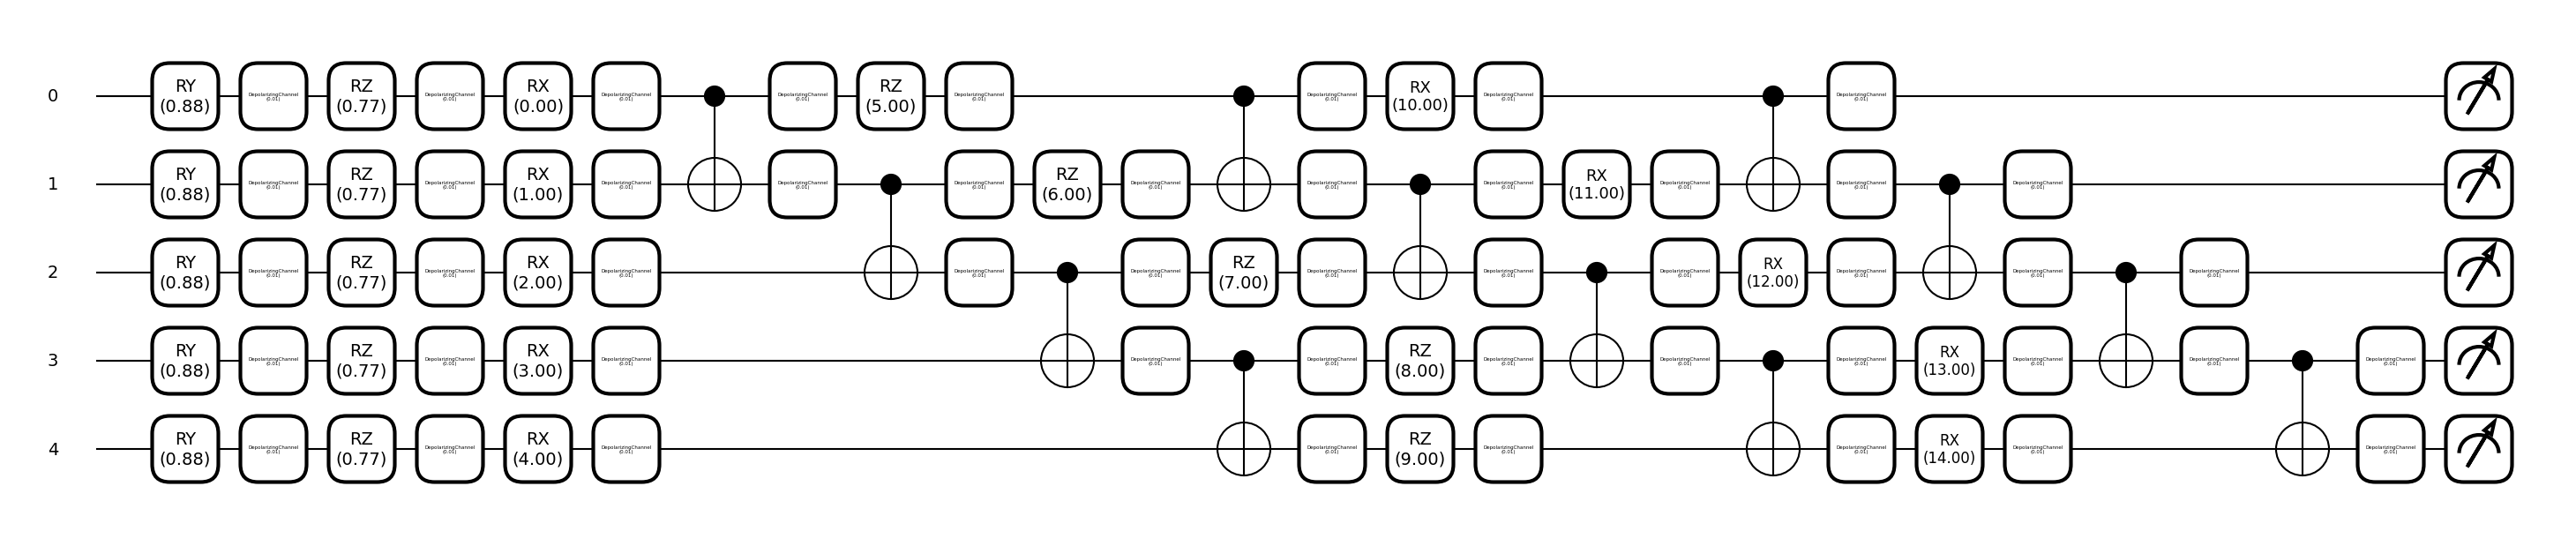

In [19]:
qml.draw_mpl(
    qnn,
    decimals=2,
    expansion_strategy="device",  ### comment if you want to see division of encoding and variational ansatz
)(
    X[0],
    np.arange(params_per_layer * layers, dtype=float),
)

# Noise on QFIM

In [20]:
### necessary tools
def inner_prod_jax(
    grad_params,
    params,
    x,
):
    """
    Jax is differenciating with respect to grad params, the second argument of the function.
    """
    if design == "2design":
        rho1 = qnn(x, grad_params)
        rho2 = qnn(x, params)
    elif design == "paper_model":
        rho1 = qnn(x, grad_params)
        rho2 = qnn(
            x,
            params,
        )

    if len(rho1.shape) == 1:
        return jnp.abs(jnp.vdot(rho1, rho2)) ** 2

    return qml.math.fidelity(rho1, rho2)


def hessian(f):
    return jax.jacfwd(jax.jacrev(f))

With the following cell you can calculate the QFIM and its eigenvalues for different values of noise:

In [ ]:
def dataset_eigvs_qfim_jax(params, X):
    """Average over training set."""
    qfims = []

    seed = 12345
    for i, x in enumerate(X):
        print(f"Sample {i:3}/{len(X)}", end="\r")

        key = jax.random.PRNGKey(seed)

        # initializing 5 different param vectors
        for _ in range(5):
            key = jax.random.split(key)[0]
            random_params = jax.random.normal(key, shape=(layers * params_per_layer,))

            ### possible improvement by "mapping" the function on X
            _qfim = get_qfim_jax(
                random_params,
                x,
            )

            qfims.append(_qfim)

    return qfims


dataset = "sin"
design = "2design"

if design == "2design":
    n_qubits = 5
    inner_layers = 3
    layers_list = [4, 10]  ## under- and over- parametrized

elif design == "paper_model":  # QNN model from arXiv:2410.19921
    n_qubits = 4
    inner_layers = 2
    layers_list = [3, 5]  ## under- and over- parametrized


seed = 12345
key = jax.random.PRNGKey(seed)

noise_values = (
    np.array(
        [
            0,
            1e-5,
            1e-3,
            5e-3,
            1e-2,
            2e-2,
            3e-2,
            4e-2,
            5e-2,
            6e-2,
            7e-2,
            8e-2,
            9e-2,
            1e-1,
            2e-1,
            4e-1,
            7e-1,
        ]
    )
    * 1e-1
)
if design == "paper_model":
    noise_values = np.concatenate(
        [noise_values, [10**i for i in np.linspace(-3, 0, 13)]]
    )
    noise_values = np.concatenate([noise_values, np.array([3, 5, 6, 8, 9]) * 1e-2])


for layers in layers_list:
    for noise_type in ["depolarizing", "phase_damp", "ampl_damp"]:  #
        dir_path = "."
        data_folder = (
            dir_path
            + f"/data/NIE/{dataset}/{design}/{noise_type}/{layers}_layers/QFIMs"
        )
        os.makedirs(data_folder, 0o755, exist_ok=True)

        for p in noise_values:
            print(f"layers {layers}-{noise_type} {p:.6f}")

            if design == "2design":
                qnn = create_circuit(
                    n_qubits,
                    layers,
                    p=p,
                    noise_type=noise_type,
                )

            elif design == "paper_model":  # QNN model from arXiv:2410.19921
                qnn = create_circuit_diabetes(
                    n_qubits,
                    layers,
                    p=p,
                    noise_type=noise_type,
                )

            random_params = jax.random.normal(key, shape=(layers * params_per_layer,))

            @jax.jit  ## Just-in-time compilation
            def get_qfim_jax(
                params,
                x,
            ):
                n_params = len(params)
                qfim = -0.5 * hessian(inner_prod_jax)(
                    params,
                    params,
                    x,
                )
                qfim = jnp.reshape(qfim, (n_params, n_params))
                return qfim

            qfims = dataset_eigvs_qfim_jax(
                random_params,
                X,
            )

            print()
            ## save all noise levels separately
            np.save(
                data_folder + f"/{dataset}_QFIMs_noisy_{p}.npy", {p: np.array(qfims)}
            )

# NIE visualisation

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation
from matplotlib import cm
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

[1.e-06 1.e-04 1.e-03 5.e-03 1.e-02 2.e-02 4.e-02 7.e-02]


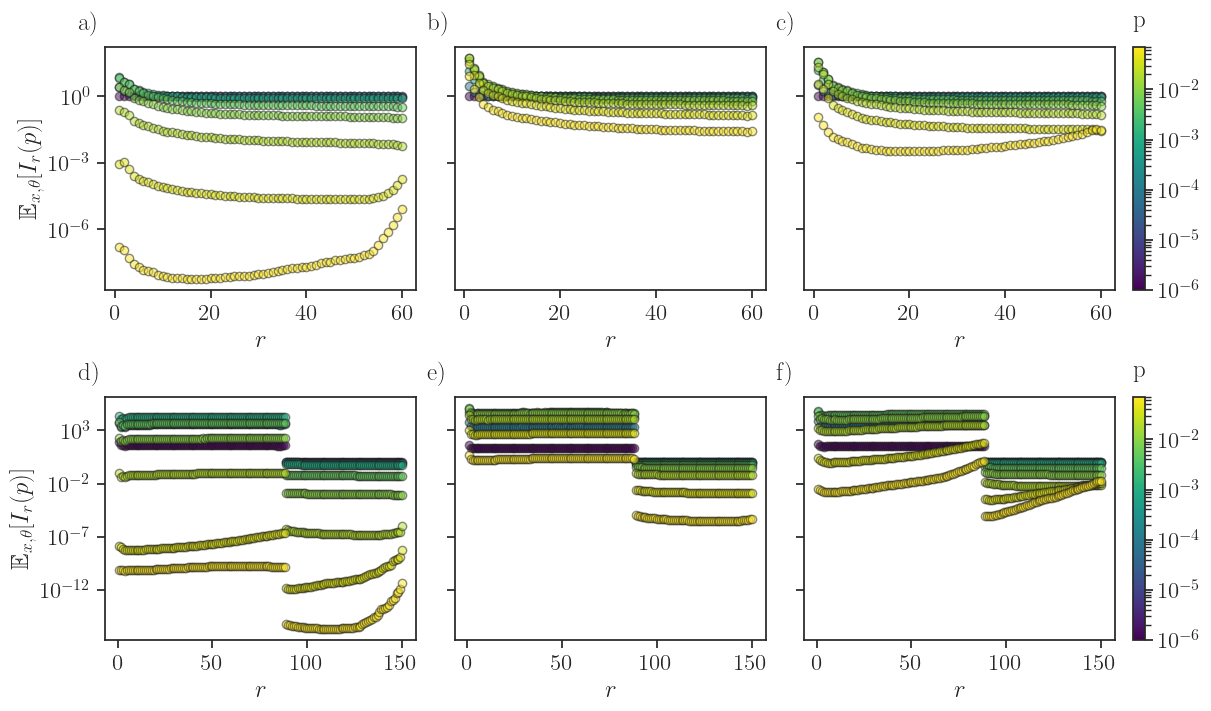

In [9]:
sns.set(font_scale=1.5)
sns.set_style("ticks")

mpl.pyplot.rc("text", usetex=True)
mpl.pyplot.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.sans-serif": "Computer Modern",
        "text.latex.preamble": r"\usepackage{amsfonts}",
    }
)

markers = [
    ".",
    "o",
    "v",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    "*",
    "h",
    "H",
    "D",
    "d",
    "P",
    "X",
] + list(range(12))

noise_values = np.array([1e-5,1e-3,5e-3, 
                           1e-2,2e-2, 3e-2,4e-2,5e-2, 6e-2,7e-2,8e-2,9e-2,
                           1e-1,2e-1,4e-1, 7e-1])*1e-1

labels = ["a)", "b)", "c)", "d)", "e)", "f)"]

fig, ax = plt.subplots(2, 3, figsize=(12, 7), sharey="row", layout="constrained")

dataset = "sin"
design = "2design"

if design == "2design":
    n_qubits = 5
    inner_layers = 3

    layers_list = [4, 10]

    norm = mpl.colors.LogNorm(vmin=np.min(noise_values), vmax=np.max(noise_values))
    cmap = sns.color_palette("viridis", as_cmap=True)

    # reduced number of noise levels
    noise_values = np.array([1e-5, 1e-3, 1e-2, 5e-2, 1e-1, 2e-1, 4e-1, 7e-1]) * 1e-1  #
    scaler = MinMaxScaler(feature_range=(0, 1))
    noise_colors = scaler.fit_transform(
        np.log10(np.reshape(noise_values, newshape=(noise_values.shape[0], 1)))
    )

elif design == "paper_model":
    n_qubits = 4
    inner_layers = 2

    layers_list = [3, 5]

    noise_values = np.array(
        sorted(list(noise_values[1:]) + [10**i for i in np.linspace(-3, 0, 13)])
    )

    norm = mpl.colors.LogNorm(vmin=np.min(noise_values), vmax=np.max(noise_values))
    cmap = sns.color_palette("viridis", as_cmap=True)

    # reduced number of noise levels
    noise_values = np.array(
        [1e-3 * 1e-1] + [10**i for i in np.linspace(-3, 0, 13)][::2]
    )
    scaler = MinMaxScaler(feature_range=(0, 1))
    noise_colors = scaler.fit_transform(
        np.log10(np.reshape(noise_values, newshape=(noise_values.shape[0], 1)))
    )

for l, layers in enumerate(layers_list):
    for noise_idx, noise_type in enumerate(
        [
            "depolarizing",
            "phase_damp",
            "ampl_damp",
        ]
    ):
        dir_path = "."  # os.path.dirname(absolute_path)
        data_folder = (
            dir_path
            + f"/data/NIE/{dataset}/{design}/{noise_type}/{layers}_layers/QFIMs"
        )

        # creating a dictionary of eigenvals
        gather_eigvs = {}
        for p in np.concatenate([[0.0], noise_values]):
            qfims = np.load(
                data_folder + f"/{dataset}_QFIMs_noisy_{p}.npy", allow_pickle=True
            )[()][
                p
            ]  # v[-1]
            w_s = list(map(lambda x: eigh(x)[0], qfims))
            w_s = np.sort(np.abs(w_s))
            gather_eigvs[p] = np.array(w_s)
        mean_increase = []

        for i, p in enumerate(sorted(noise_values)):
            # increase = gather_eigvs[p] / (gather_eigvs[0.0])
            noiseless_eigvs = np.fmax(
                np.array(gather_eigvs[0.0], dtype=np.float64), 
                np.ones(shape=np.array(gather_eigvs[0.0]).shape)*1e-10
            )

            increase = np.array(gather_eigvs[p], dtype=np.float64) / noiseless_eigvs

            mean_increase = np.mean(increase, axis=0)
            std_increase = np.std(increase, axis=0)

            points = ax[l][noise_idx].scatter(
                range(1, 1 + n_qubits * layers * inner_layers),
                mean_increase,
                label=f"{p:.5f}",
                color=cmap(noise_colors[i]),
                marker="o",
                alpha=0.5,
                edgecolor="k",
            )  # markers[i],

        ax[l][noise_idx].set_yscale("log")
        ax[l][noise_idx].set_xlabel(r"$r$")

        ax[l][noise_idx].text(
            0.0,
            0.99,
            labels[l * 3 + noise_idx],
            transform=(
                ax[l][noise_idx].transAxes
                + ScaledTranslation(-20 / 72, +10 / 72, fig.dpi_scale_trans)
            ),
            weight="bold",
            # fontsize='medium',
            va="bottom",
            # fontfamily='serif'
        )

    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=norm,
            cmap=cmap,
        ),
        ax=ax[l][2],
        orientation="vertical",
    )
    cbar.ax.set_title("p", y=1.05)
    ax[l][0].set_ylabel(r"$\mathbb{E}_{x,\theta}[I_r(p)]$")
print(noise_values)
# plt.subplots_adjust(hspace=1)
# plt.tight_layout()


plot_folder = f"./plots/NIE/{dataset}/"
os.makedirs(plot_folder, 0o755, exist_ok=True)
fig.savefig(
    plot_folder + f"increase_eigenv_{dataset}_{layers}.pdf",
    bbox_inches="tight",
    pad_inches=0.25,
)

### Average increase $\bar{I}_{R_{max}}(p)$

In [ ]:
from NIE_tools import gather_QFIMs_eigvals_diff_noise, find_R_max, I_r_trend_truncated

n_run = 10
epochs = 1000

dir_path = "."  # os.path.dirname(absolute_path)

noise_values = (
    np.array(
        [
            0,
            1e-5,
            1e-3,
            5e-3,
            1e-2,
            2e-2,
            3e-2,
            4e-2,
            5e-2,
            6e-2,
            7e-2,
            8e-2,
            9e-2,
            1e-1,
            2e-1,
            4e-1,
            7e-1,
        ]
    )
    * 1e-1
)  #

dataset = "diabetes"  # 'sin2' #
design =  'paper_model' # "2design"  #
noise_type = "ampl_damp"


layers = 5
print(noise_type, layers, design)


if design == "2design":
    n_qubits = 5
    inner_layers = 3
    if dataset == "regr_moons":
        noise_values = np.concatenate([noise_values, [0.1, 0.3, 0.5, 0.7, 1]])
elif design == "paper_model":
    n_qubits = 4
    inner_layers = 2
    noise_values = np.concatenate(
        [noise_values, [10**i for i in np.linspace(-3, 0, 13)]]
    )[:]
    noise_values = np.concatenate([noise_values, np.array([3, 5, 8, 9]) * 1e-2])


params_per_layer = inner_layers * n_qubits

##### QFIM analysis
data_folder_overp = (
    dir_path + f"/data/NIE/{dataset}/{design}/{noise_type}/{layers}_layers/QFIMs"
)


# creating a dictionary gathering all noise levels
gather_eigvs = gather_QFIMs_eigvals_diff_noise(noise_values, dataset, data_folder_overp)

## we determin R_max,
## the index separating the eigenvalues that can grow from the one that are supppressed
R_max = find_R_max(noise_values, gather_eigvs)

## removing noiseless case
noise_values_plotting = sorted(noise_values)[1:]

## compute I_r only for the eigenvalues that can grow
increases_list, mean_increase, std_increase = I_r_trend_truncated(
    gather_eigvs, R_max, noise_values_plotting
)

### increases_list has shape = (noise_values, R_max)

## computing p* inducing the best NIE
opt_p_list_qfim = []
for I_r_runs in np.array(
    increases_list, dtype=object
).T:  # per each eigenval r we have multiple runs with different values of p
    ## np.array(increases_list).T.shape = (eigenvals, inputs x runs, noise_levels)

    tmp = list(map(lambda x: noise_values_plotting[np.nanargmax(x)], I_r_runs))
    opt_p_list_qfim.append(tmp)

mean_p_qfim = np.mean(opt_p_list_qfim)
std_p_qfim = np.std(opt_p_list_qfim)
print(dataset, rf"p* from QFIM: {mean_p_qfim:.4f} ± {std_p_qfim:.4f}")

(1e-06, 1121673.0135152498)

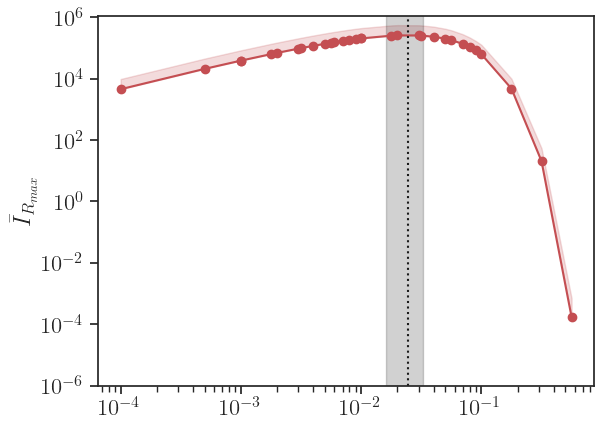

In [5]:
sns.set(font_scale=1.5)
sns.set_style("ticks")

mpl.pyplot.rc("text", usetex=True)
mpl.pyplot.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.sans-serif": "Computer Modern",
        "text.latex.preamble": r"\usepackage{amsfonts}",
    }
)

fig, ax = plt.subplots()

plt.plot(
    noise_values_plotting, mean_increase, c=sns.color_palette("deep")[3], marker="o"
)

plt.fill_between(
    noise_values_plotting,
    mean_increase,  #
    mean_increase + std_increase,
    color=sns.color_palette("deep")[3],
    alpha=0.2,
)


### mean of argmax
plt.vlines(
    np.mean(opt_p_list_qfim),
    0,
    10**16,
    linestyle="dotted",
    color="k",
    label=r"$p^*$ NID",
)

plt.fill_betweenx(
    [0, 10**16],
    mean_p_qfim - std_p_qfim,
    mean_p_qfim + std_p_qfim,
    color="k",
    alpha=0.2,
)

ax.set_ylabel(r"$\bar{{I}}_{R_{max}}$")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(10**-6, np.nanmax(mean_increase + std_increase) * 2)